# Inglewood - Open Street Map Project

Inglewood, California, United states

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#audit">Data Wrangling</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>   
<li><a href="#analysis">Exploratory Data Analysis</a></li>
<li><a href="#conclusion">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

I chose Inglewood, California because this was where I was born and raised.  So I was curious about this dataset.
<ul>
    <li><a href="https://www.openstreetmap.org/relation/112090">Inglewood, CA - Map</a></li>
</ul>

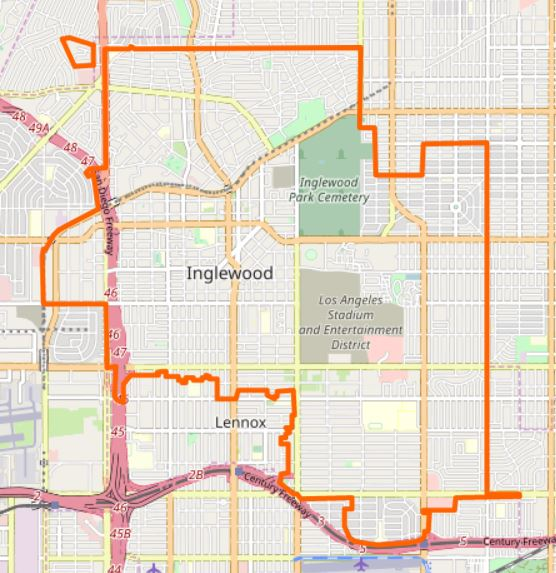

<a id='audit'></a>
## Data Audit

Initially going through the data I was surprised to find it fairly clean.  Below are the audits I ran against this dataset.

In [9]:
# Libraries being used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.cElementTree as ET
import pprint
import re
import csv
from collections import defaultdict
import schema
import cerberus
import codecs
import datetime as dt
from sqlalchemy import create_engine, Table, Column, Integer, Float, String, MetaData, ForeignKey
import sqlite3
import unicodecsv

# Map file

OSM_FILE = 'inglewood_map'

In [2]:
# Counting each tag category in a dictionary.  
# Check 'lower', 'lower_colon' and 'problemchars'
# File = tags_types.py


lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

def key_type(element, keys):
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys['lower'] += 1
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon'] += 1
        elif problemchars.search(element.attrib['k']):
            keys['problemchars'] += 1
        else:
            keys['other'] += 1

    return keys

def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

keys = process_map(OSM_FILE)
pprint.pprint(keys)

{'lower': 390447, 'lower_colon': 280832, 'other': 1241, 'problemchars': 0}


In [3]:
# Iterative parsing to process the map file and find out the tags.
# File = tags.py

def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

tags = count_tags(OSM_FILE)
pprint.pprint(tags)

{'bounds': 1,
 'member': 23936,
 'meta': 1,
 'nd': 1107805,
 'node': 995092,
 'note': 1,
 'osm': 1,
 'relation': 1012,
 'tag': 672520,
 'way': 102583}


In [41]:
# Auditing Street Names
# File = street_name_audit.py

street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

# valid street names
# Added 'Cienega' and 'Thornburn' because they are valid street names.

expected_street_types = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Commons", "Northeast", "South", "Southeast", "Southwest","Northwest",
            "East", "West", "North", "Highway", "Way", "Terrace", "Freeway", "Highway", "Point", 
           "Alley", "Circle", "Cienega", "Thornburn"]

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected_street_types:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "rb")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types


def update_street_name(value):
    m = street_type_re.search(value)
    if m:
        if m.group() in street_type_mapping:
            startpos = value.find(m.group())
            value = value[:startpos] + street_type_mapping[m.group()]
        return value
    else:
        return None

st_types = audit(OSM_FILE)
pprint.pprint(dict(st_types))

{'426': {'5250 W. Century Blvd Suite 426'},
 'A-B': {'West Manchester Avenue  Unit A-B'},
 'Ave': {'Jack Northrup Ave', 'Centinela Ave'},
 'BLVD': {'CRENSHAW BLVD'},
 'Bld.': {'W Century Bld.'},
 'Blv.': {'W Century Blv.'},
 'Blvd': {'Aviation Blvd',
          'E Manchester Blvd',
          'East Manchester Blvd',
          'S La Cienega Blvd',
          'W Century Blvd',
          'West Century Blvd'},
 'St': {'I-105 @ Hawthorne Blvd & 111th St'}}


In [4]:
# Auditing Postal Codes
# File = postalcode_audit.py

post_code_re = re.compile(r'^\d{5}$')

def audit_post_codes(bad_post_codes, post_code):
    m = post_code_re.match(post_code)
    if not m:
        bad_post_codes.add(post_code)

def is_post_code(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit(osmfile):
    osm_file = open(osmfile, "rb")
    bad_post_codes = set()
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_post_code(tag):
                    audit_post_codes(bad_post_codes, tag.attrib['v'])

    osm_file.close()
    return bad_post_codes



postal_types = audit(OSM_FILE)
pprint.pprint(postal_types)

{'90250-4638', '90045-5663', '90047-1130'}


In [48]:
# Preparing the database - SQL
# File = ing.import.py

"""
After auditing is complete the next step is to prepare the data to be inserted into a SQL database.
To do so you will parse the elements in the OSM XML file, transforming them from document format to
tabular format, thus making it possible to write to .csv files.  These csv files can then easily be
imported to a SQL database as tables.

The process for this transformation is as follows:
- Use iterparse to iteratively step through each top level element in the XML
- Shape each element into several data structures using a custom function
- Utilize a schema and validation library to ensure the transformed data is in the correct format
- Write each data structure to the appropriate .csv files

We've already provided the code needed to load the data, perform iterative parsing and write the
output to csv files. Your task is to complete the shape_element function that will transform each
element into the correct format. To make this process easier we've already defined a schema (see
the schema.py file in the last code tab) for the .csv files and the eventual tables. Using the 
cerberus library we can validate the output against this schema to ensure it is correct.

## Shape Element Function
The function should take as input an iterparse Element object and return a dictionary.

### If the element top level tag is "node":
The dictionary returned should have the format {"node": .., "node_tags": ...}

The "node" field should hold a dictionary of the following top level node attributes:
- id
- user
- uid
- version
- lat
- lon
- timestamp
- changeset
All other attributes can be ignored

The "node_tags" field should hold a list of dictionaries, one per secondary tag. Secondary tags are
child tags of node which have the tag name/type: "tag". Each dictionary should have the following
fields from the secondary tag attributes:
- id: the top level node id attribute value
- key: the full tag "k" attribute value if no colon is present or the characters after the colon if one is.
- value: the tag "v" attribute value
- type: either the characters before the colon in the tag "k" value or "regular" if a colon
        is not present.

Additionally,

- if the tag "k" value contains problematic characters, the tag should be ignored
- if the tag "k" value contains a ":" the characters before the ":" should be set as the tag type
  and characters after the ":" should be set as the tag key
- if there are additional ":" in the "k" value they and they should be ignored and kept as part of
  the tag key. For example:

  <tag k="addr:street:name" v="Lincoln"/>
  should be turned into
  {'id': 12345, 'key': 'street:name', 'value': 'Lincoln', 'type': 'addr'}

- If a node has no secondary tags then the "node_tags" field should just contain an empty list.

The final return value for a "node" element should look something like:

{'node': {'id': 757860928,
          'user': 'uboot',
          'uid': 26299,
       'version': '2',
          'lat': 41.9747374,
          'lon': -87.6920102,
          'timestamp': '2010-07-22T16:16:51Z',
      'changeset': 5288876},
 'node_tags': [{'id': 757860928,
                'key': 'amenity',
                'value': 'fast_food',
                'type': 'regular'},
               {'id': 757860928,
                'key': 'cuisine',
                'value': 'sausage',
                'type': 'regular'},
               {'id': 757860928,
                'key': 'name',
                'value': "Shelly's Tasty Freeze",
                'type': 'regular'}]}

### If the element top level tag is "way":
The dictionary should have the format {"way": ..., "way_tags": ..., "way_nodes": ...}

The "way" field should hold a dictionary of the following top level way attributes:
- id
-  user
- uid
- version
- timestamp
- changeset

All other attributes can be ignored

The "way_tags" field should again hold a list of dictionaries, following the exact same rules as
for "node_tags".

Additionally, the dictionary should have a field "way_nodes". "way_nodes" should hold a list of
dictionaries, one for each nd child tag.  Each dictionary should have the fields:
- id: the top level element (way) id
- node_id: the ref attribute value of the nd tag
- position: the index starting at 0 of the nd tag i.e. what order the nd tag appears within
            the way element

The final return value for a "way" element should look something like:

{'way': {'id': 209809850,
         'user': 'chicago-buildings',
         'uid': 674454,
         'version': '1',
         'timestamp': '2013-03-13T15:58:04Z',
         'changeset': 15353317},
 'way_nodes': [{'id': 209809850, 'node_id': 2199822281, 'position': 0},
               {'id': 209809850, 'node_id': 2199822390, 'position': 1},
               {'id': 209809850, 'node_id': 2199822392, 'position': 2},
               {'id': 209809850, 'node_id': 2199822369, 'position': 3},
               {'id': 209809850, 'node_id': 2199822370, 'position': 4},
               {'id': 209809850, 'node_id': 2199822284, 'position': 5},
               {'id': 209809850, 'node_id': 2199822281, 'position': 6}],
 'way_tags': [{'id': 209809850,
               'key': 'housenumber',
               'type': 'addr',
               'value': '1412'},
              {'id': 209809850,
               'key': 'street',
               'type': 'addr',
               'value': 'West Lexington St.'},
              {'id': 209809850,
               'key': 'street:name',
               'type': 'addr',
               'value': 'Lexington'},
              {'id': '209809850',
               'key': 'street:prefix',
               'type': 'addr',
               'value': 'West'},
              {'id': 209809850,
               'key': 'street:type',
               'type': 'addr',
               'value': 'Street'},
              {'id': 209809850,
               'key': 'building',
               'type': 'regular',
               'value': 'yes'},
              {'id': 209809850,
               'key': 'levels',
               'type': 'building',
               'value': '1'},
              {'id': 209809850,
               'key': 'building_id',
               'type': 'chicago',
               'value': '366409'}]}
"""

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
"""Regular expression to recognise problem characters"""

SCHEMA = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}


# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']



# Update Street Names  
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

# valid street names
expected_street_types = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Commons", "Northeast", "South", "Southeast", "Southwest","Northwest",
            "East", "West", "North", "Highway", "Way", "Terrace", "Freeway", "Highway", "Point", 
           "Alley", "Circle", "426", "Ic"]

street_type_mapping = { "Ave": "Avenue",
            "Blvd": "Boulevard",
            "Bld.": "Boulevard",
            "Blv.": "Boulevard",
            "St": "Street"
          }

def update_street_name(value):
    m = street_type_re.search(value)
    if m:
        if m.group() in street_type_mapping:
            startpos = value.find(m.group())
            value = value[:startpos] + street_type_mapping[m.group()]
        return value
    else:
        return None

    
# Audit and update postal codes
postcode_re = re.compile(r'^\d{5}$')

def audit_post_codes(post_codes, post_code):
    m = post_code_re.match(post_code)
    if not m:
        post_codes.add(post_code)

def is_postcode(elem):
    return (elem.attrib['k'] == "addr:postcode")
def audit(osmfile):
    osm_file = open(osmfile, "rb")
    post_codes = set()
    bad_postcode = set()
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
               if is_postcode(tag):
                    m = postcode_re.search(tag.attrib['v'])
                    if m:
                        post_codes.add(tag.attrib['v'])  
                    else:
                        bad_postcode.add(tag.attrib['v'])

    osm_file.close()
    return (bad_postcode)

# Split the post code at the "-" and return the first part
def update_postcode(bad_postcode):
    postcode = bad_postcode.split("-")[0]
    return postcode

# Update Tags for street names and postal codes
def update_tag(tag):
    if tag['key'] == "street":
        tag['value'] = update_name(tag['value'], street_type_mapping)
    elif tag['key'] == "postcode":
        tag['value'] = update_postcode(tag['value'])

    
"""Clean and shape node or way XML element to Python dict."""

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    
    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    # Write the value of each node element attribute into a dictionary.
    if element.tag == 'node':
        for field in NODE_FIELDS:  
            # node_attribs contains top level node attributes
            node_attribs[field] = element.attrib[field]
           
        for child in element: 
            # Create dictionary for child tag
            child_tag = {}
            value_k = child.attrib['k']
            child_tag['id'] = node_attribs['id']
            # If tag "k" contains problematic characters, ignore it
            if PROBLEMCHARS.search(value_k): 
                continue
            # If the k attribute contains ":" - Take the first part as type, and the remainder as key.
            elif LOWER_COLON.search(value_k):
                value_k_split = value_k.split(':', 1)
                child_tag['type'] = value_k_split[0]
                child_tag['key'] = value_k_split[1]
                child_tag['value'] = child.attrib['v']
            # Else assign the attribute value to the keys
            else: 
                child_tag['key'] = value_k
                child_tag['value'] = child.attrib['v']
                child_tag['type'] = default_tag_type

        
            # Append dictionary tag to list tags
            tags.append(child_tag) 
        
        return {'node': node_attribs, 'node_tags': tags}
        
    # Write the value of each way element attribute into a dictionary.    
    elif element.tag == 'way':
        for field in WAY_FIELDS:  
            # way_attribs contains top level way attributes
            way_attribs[field] = element.attrib[field]
        
        counter = 0
        for child in element:
            # Create dictionary for child tag
            child_tag = {}
            if child.tag == 'tag':  
                value_k = child.attrib['k']
                child_tag['id'] = way_attribs['id']
                # If tag "k" contains problematic characters, ignore it
                if PROBLEMCHARS.search(value_k): 
                    continue
                # If the k attribute contains ":" - Take the first part as type, and the remainder as key.
                elif LOWER_COLON.search(value_k): 
                    value_k_split = value_k.split(':', 1)
                    child_tag['type'] = value_k_split[0]
                    child_tag['key'] = value_k_split[1]
                    child_tag['value'] = child.attrib['v']
                # Else assign the attribute value to the keys
                else: 
                    child_tag['key'] = value_k
                    child_tag['value'] = child.attrib['v']
                    child_tag['type'] = default_tag_type

                # Append dictionary tag to list tags
                tags.append(child_tag) 
            
            if child.tag =='nd': #
                way_node = {}
                way_node['id'] = way_attribs['id']
                way_node['node_id'] = child.attrib['ref']
                way_node['position'] = counter
                counter += 1
                way_nodes.append(way_node)
                
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}

# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag."""
   
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema."""
    
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate=False):

    with open(NODES_PATH, 'wb') as nodes_file, \
         open(NODE_TAGS_PATH, 'wb') as nodes_tags_file, \
         open(WAYS_PATH, 'wb') as ways_file, \
         open(WAY_NODES_PATH, 'wb') as way_nodes_file, \
         open(WAY_TAGS_PATH, 'wb') as way_tags_file:

        nodes_writer = unicodecsv.DictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = unicodecsv.DictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = unicodecsv.DictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = unicodecsv.DictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = unicodecsv.DictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])
                    
process_map(OSM_FILE)

<a id='cleaning'></a>
## Data Cleaning


### Converting the data into CSVs

After auditing the data, I exported the xml data into csv using 'ing_import.py'

Once the data was cleaned and imported to csv.  I then imported the csv files into a database using 'create_db.py'.  I ran it in 'inglewood_data_explore.ipynb'

In [49]:
# Create Database called 'inglewood.db'
engine = create_engine('sqlite:///inglewood.db') 

# Create tables within the Database
metadata = MetaData()

nodes = Table('nodes', metadata,
    Column('id', Integer, primary_key=True, nullable=False),
    Column('lat', Float),
    Column('lon', Float),
    Column('user', String),
    Column('uid', Integer),
    Column('version', String),
    Column('changeset', Integer),
    Column('timestamp', String)
)

nodes_tags = Table('nodes_tags', metadata,
    Column('id', Integer, ForeignKey('nodes.id'), nullable=False),
    Column('key', String),
    Column('value', String),
    Column('type', String),
)

ways = Table('ways', metadata,
    Column('id', Integer, primary_key=True, nullable=False),
    Column('user', String),
    Column('uid', Integer),
    Column('version', String),
    Column('changeset', Integer),
    Column('timestamp', String)
)

ways_tags = Table('ways_tags', metadata,
    Column('id', Integer, ForeignKey('ways.id'), nullable=False),
    Column('key', String),
    Column('value', String),
    Column('type', String),
)

ways_nodes = Table('ways_nodes', metadata,
    Column('id', Integer, ForeignKey('ways.id'), nullable=False),
    Column('node_id', Integer, ForeignKey('nodes.id'), nullable=False),
    Column('position', Integer, nullable=False)
)

metadata.create_all(engine)

# Load csv files into Python Pandas DataFrames, then load them into SQLite database 
def csv_to_db(csvfile, table):
    print('Loading {}'.format(csvfile))
    start = dt.datetime.now()
    chunksize = 200000
    j = 0
    for df in pd.read_csv(csvfile, chunksize=chunksize, iterator=True, encoding='utf-8'):
        j+=1
        df.to_sql(table, engine, if_exists='append', index=False)

csv_to_db('nodes.csv', 'nodes')
csv_to_db('nodes_tags.csv', 'nodes_tags')
csv_to_db('ways.csv', 'ways')
csv_to_db('ways_tags.csv', 'ways_tags')
csv_to_db('ways_nodes.csv', 'ways_nodes')

Loading nodes.csv
Loading nodes_tags.csv
Loading ways.csv
Loading ways_tags.csv
Loading ways_nodes.csv


<a id='analysis'></a>
## Exploratory Data Analysis

Once everything was imported into a database I began to explore the data.



#### File Sizes

<ul>
    <li>inglewood_map  -  230MB</li>
    <li>inglewood.db  -  131MB</li>
    <li>nodes.csv  -  93.6MB</li>
    <li>nodes_tags.csv  -  213KB</li>
    <li>ways.csv  -  7.04MB</li>
    <li>ways_nodes.csv  -  26.9MB</li>
    <li>ways_tags.csv  -  22.1MB</li>
</ul>

In [30]:
# Counting the Number of Nodes

sql_query = '''
SELECT COUNT(*) AS "Number of Nodes" FROM nodes
'''
df = pd.read_sql_query(sql_query, engine)
df

,Number of Nodes
0,995092


In [44]:
# Counting the Number of Ways

sql_query = '''
SELECT COUNT(*) AS "Number of Ways" FROM ways
'''
df = pd.read_sql_query(sql_query, engine)
df

,Number of Ways
0,102583


In [32]:
sql_query = '''
SELECT COUNT(DISTINCT uid) AS "Number of Unique Users" 
FROM
(SELECT uid FROM nodes 
UNION
SELECT DISTINCT uid FROM ways);
'''
df = pd.read_sql_query(sql_query, engine)
df

,Number of Unique Users
0,563


In [45]:
# Top 10 Postal Codes

sql_query = '''
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags 
UNION ALL 
SELECT * FROM ways_tags) tags
WHERE tags.key='postcode'
GROUP BY tags.value
ORDER BY count DESC
'''

df = pd.read_sql_query(sql_query, engine)
df

,value,count
0,90008,97
1,90045,23
2,90301,17
3,90303,17
4,90043,14
5,90304,11
6,90302,8
7,90062,7
8,90250,6
9,90047,2


In [34]:
# Top 10 Contributing Users

sql_query = '''
SELECT e.user as User, COUNT(*) as Count
FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
GROUP BY e.user
ORDER BY Count DESC
LIMIT 10;'''

df = pd.read_sql_query(sql_query, engine)
df

,User,Count
0,schleuss_imports,260899
1,manings_labuildings,120518
2,Luis36995_labuildings,119068
3,RichRico_labuildings,93883
4,calfarome_labuilding,74635
5,priya_imports,54218
6,kingrollo_imports,48360
7,yurasi_import,41844
8,dima_import,26592
9,ridixcr_import,23375


In [35]:
# Top 10 Amenities

sql_query = '''
select value, count(distinct id) 
from nodes_tags 
where key = 'amenity' 
group by 1 
order by 2 desc 
limit 10;
'''
df = pd.read_sql_query(sql_query, engine)
df

,value,count(distinct id)
0,place_of_worship,77
1,school,39
2,fast_food,21
3,car_rental,14
4,restaurant,14
5,fuel,12
6,library,8
7,fire_station,7
8,bank,5
9,post_office,5


In [36]:
sql_query = '''
SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
    JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
    ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC;'''

df = pd.read_sql_query(sql_query, engine)
df

,value,num
0,american,3
1,american;breakfast,1
2,cuban,1
3,fried_chicken,1
4,mediterranean;ethiopian,1
5,mexican,1
6,steak_house,1


In [69]:
# What are the most popular Religions based on places of worship.

sql_query = '''
SELECT ways_tags.value as 'Religion', COUNT(*) as Count
FROM ways_tags
    JOIN (SELECT DISTINCT(id) FROM ways_tags WHERE value='place_of_worship') a
    ON ways_tags.id=a.id
WHERE ways_tags.key='religion'
GROUP BY ways_tags.value
ORDER BY Count DESC;'''

df = pd.read_sql_query(sql_query, engine)
df

,Religion,Count
0,christian,5


In [34]:
# Show the different cities in this dataset.
# Even though I chose Inglewood there are more 'Los Angeles' entries.

sql_query = '''
SELECT tags.value, COUNT(*) as count 
FROM (SELECT * FROM nodes_tags UNION ALL 
      SELECT * FROM ways_tags) tags
WHERE tags.key = 'city'
GROUP BY tags.value
ORDER BY count DESC;'''

df = pd.read_sql_query(sql_query, engine)
df

,value,count
0,Los Angeles,141
1,Inglewood,41
2,Hawthorne,6
3,Lennox,5
4,El Segundo,1
5,los angeles,1


<a id='conclusion'></a>
## Conclusion

As a result of going through this dataset, I realized that it is fairly clean.  I was able to make some improvements on street names where there were some inconsistencies in the naming comvention.  There were a few postal codes that had the extended format of xxxxx-xxx, so I decided to re-format those few exceptions to the xxxxx format.  I also noticed that even though I chose Inglewood, CA from the openstreetmap, I got a lot of addresses from Los Angeles.  

After auditing this dataset I imported it to csv files using the script from the case study. Then I imported the csv files into a sqlite database.  I considered going with sqlite in Pandas but I decided to try sqlalchemy instead.  I then was a able to run SQL queries to really explore the dataset.

Additional ideas:
<ul>
    <li>If I wanted to strictly audit the city of Inglewood California, I would remove all of the city data that does not equal to Inglewood</li>  
    <li>I could also audit all of the different tags for uniformity.  Such as postcodes, amenities and etc.  I'm sure there is more room to clean up there.</li>
</ul>


<a id='references'></a>
## References

<ol>
    <li><a href="https://wiki.openstreetmap.org/wiki/OSM_XML">OSM XML Wiki</a></li>
    <li><a href="https://docs.python.org/2/library/xml.etree.elementtree.html#module-xml.etree.ElementTree">xml.etree.ElemetTree Docs</a></li>
    <li>Sqlite:</li>  
    <ol>
        <li><a href="https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python">CSV to sqlite database - stackoverflow</a></li>
        <li><a href="https://plot.ly/python/big-data-analytics-with-pandas-and-sqlite/">Pandas and sqlite</a></li>
        <li><a href="https://docs.python.org/3/library/sqlite3.html">sqlite3 Docs</a></li>
    </ol>   
    <li>Sqlalchemy:</li>
    <ol>
        <li><a href="https://docs.sqlalchemy.org/en/13/core/engines.html">Sqlalchemy Docs</a></li>
        <li><a href="http://www.mapfish.org/doc/tutorials/sqlalchemy.html">Sqlalchemy Tutorials</a></li>
    </ol>
        
</ol>